In [1]:
import numpy as np

import unicodedata
import re
import json
import random

import nltk
from nltk.stem.porter import PorterStemmer	
stemmer = PorterStemmer()

from transformers import BertTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoModelForCausalLM, AutoTokenizer

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm

from peft import LoraConfig, get_peft_model, IA3Config,  TaskType
import pickle

import warnings 
warnings.filterwarnings('ignore')


In [2]:
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from lightning import Fabric
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from peft import LoraConfig, get_peft_model, IA3Config,  TaskType

In [3]:
from Get_Data import GetData

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# !!!! Тут хардкожу CPU, т.к. у меня не хватате памяти для обучения на видеокарте
device = 'cpu'

In [5]:
# from huggingface_hub import login
# login()

In [6]:
dialog_question, dialog_answer = GetData()

In [7]:
def split_data(questions, answers, test_size=0.2):
    X = [questions[i] + ' ' + answers[i] for i in range(len(questions))]
    y = [1] * len(questions) 

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)

    return X_train, X_val, y_train, y_val

In [8]:
train_text, val_text, train_labels, val_labels = split_data(dialog_question, dialog_answer)

In [9]:
def prepare_tokens(tokenizer, text, max_len=50):
    tokens = tokenizer.batch_encode_plus(
        text,
        max_length = max_len,
        padding='max_length',
        truncation=True
    )
    return tokens

In [10]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-large", padding_side='left')
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-large").to(device)

In [11]:
# Установка токена паддинга
tokenizer.pad_token = tokenizer.eos_token

In [12]:
# Определение класса MyDataset, который наследуется от torch.utils.data.Dataset
class MyDataset(Dataset):
    # Конструктор класса
    def __init__(self, dialog_question, dialog_answer, tokenizer):
        # Сохранение переданных данных в атрибуты класса
        self.dialog_question = dialog_question
        self.dialog_answer = dialog_answer
        self.tokenizer = tokenizer

    # Метод, возвращающий длину датасета
    def __len__(self):
        return len(self.dialog_question)

    # Метод, возвращающий элемент датасета по указанному индексу
    def __getitem__(self, idx):
        # Получение elrian_input и leonard_target для текущего индекса
        input = self.dialog_question[idx]
        target = self.dialog_answer[idx]

        # Токенизация elrian_input с добавлением токенов паддинга и обрезкой
        tokenized_data = self.tokenizer(input, return_tensors="pt", padding=True, truncation=True)

        # Создание меток (labels) путем сдвига входной последовательности
        labels = self.tokenizer(target, return_tensors="pt", padding=True, truncation=True)["input_ids"]

         # Возвращение словаря с ключами "input_ids" и "labels", сжатых до размерности 1
        return {
            "input_ids": tokenized_data["input_ids"].squeeze(),
            "labels": labels.squeeze()
        }


In [13]:
# Создание экземпляра датасета и DataLoader
my_dataset = MyDataset(dialog_question, dialog_answer, tokenizer)
train_data_loader = DataLoader(my_dataset, batch_size=16, shuffle=True, collate_fn=lambda batch: batch)

In [14]:
# lora_config = LoraConfig(
#     r=8,
#     lora_alpha=32,
#     target_modules=["attention.self.query", "attention.self.key", "attention.self.value","attention.output.dense"],
#     lora_dropout=0.05,
#     bias="none",
#     task_type=TaskType.SEQ_CLS
# )

In [15]:
from transformers import GPT2Config

In [16]:
# Создание конфигурации для модели ChatGPT-2
chatgpt2_config = GPT2Config(
    n_embd=768,  # Размерность эмбеддингов
    n_layer=12,  # Количество слоев модели
    n_head=12,   # Количество attention heads
    n_positions=1024,  # Максимальное количество позиций в последовательности
    vocab_size=50257,   # Размер словаря
)

In [17]:
# Применение параметров из LoraConfig к ChatGPT-2 конфигурации
chatgpt2_config.lora_alpha = 16
chatgpt2_config.lora_dropout = 0.01

In [18]:
from transformers import GPT2Model, GPT2Config

In [19]:
def get_peft_model(gpt_model, chatgpt2_config):
    # Создаем модель PEFT на основе модели ChatGPT-2
    class PEFT(GPT2Model):
        def __init__(self, config):
            super().__init__(config)

            # Добавляем необходимые слои и функциональность для модели PEFT

    # Создаем экземпляр модели PEFT с переданной моделью ChatGPT-2 и конфигурацией
    peft_model = PEFT(chatgpt2_config)
    
    return peft_model

In [20]:
peft_model = get_peft_model(model, chatgpt2_config)
print(sum(param.numel() for param in peft_model.parameters() if param.requires_grad), "trainable parameters in model")

124439808 trainable parameters in model


In [21]:
best_valid_loss = float('inf')

In [22]:
optimizer = torch.optim.AdamW(peft_model.parameters(), lr = 1e-5)
cross_entropy = torch.nn.functional.binary_cross_entropy_with_logits

In [29]:
epochs = 5

In [24]:
train_losses=[]
valid_losses=[]

In [25]:
losses = []

In [30]:
# Цикл по эпохам обучения
for epoch in range(epochs):
    # Перевод модели в режим обучения
    model.train()
    # Обнуление суммарной потери на текущей эпохе
    total_loss = 0

    # Итерация по батчам в DataLoader с отображением прогресса
    for batch in tqdm(train_data_loader, desc=f"Epoch {epoch + 1}"):

        # Извлечение входных данных (input_ids) и меток (labels) из текущего батча
        inputs = batch[0]["input_ids"].to(device)
        labels = batch[0]["labels"].to(device)

        # Выравнивание длины последовательностей до минимальной длины в текущем батче
        min_length = min(inputs.size(0), labels.size(0))
        inputs = inputs[:min_length]
        labels = labels[:min_length]

        # Обнуление градиентов перед обратным распространением
        optimizer.zero_grad()

        # Получение выходов модели и вычисление потери
        outputs = model(inputs, labels=labels.flatten())
        loss = outputs.loss
        total_loss += loss.item()

        losses.append(loss.detach().numpy())

        # Обратное распространение градиентов
        loss.backward()

        # Обновление весов модели с использованием оптимизатора
        optimizer.step()

    # Вычисление средней потери на текущей эпохе и вывод информации
    average_loss = total_loss / len(train_data_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {average_loss}")


Epoch 1:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 1, Average Loss: 10.678806751071127


Epoch 2:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 2, Average Loss: 10.46139235148614


Epoch 3:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 3, Average Loss: 10.490474097206869


Epoch 4:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 4, Average Loss: 10.442482363000959


Epoch 5:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 5, Average Loss: 10.65104141153491


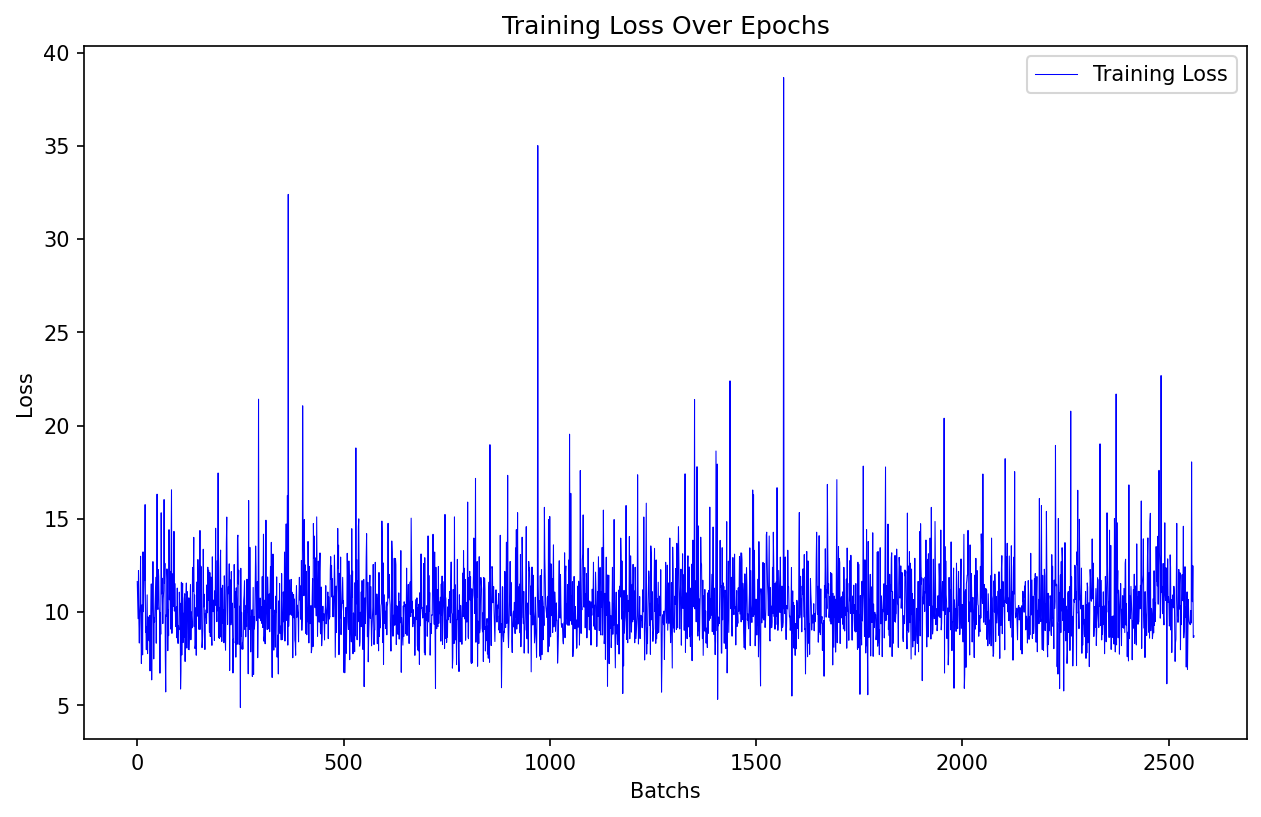

In [31]:
plt.figure(figsize=(10, 6), dpi=150)

plt.plot(range(0, len(losses)), losses, linestyle='-', color='b', linewidth=0.5, marker='', label='Training Loss')

plt.xlabel('Batchs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.show()

In [32]:
with open('./DZ2model/PEFT/losses.pkl', 'wb') as file:
    pickle.dump(losses, file)

In [33]:
model.save_pretrained("./DZ2model/PEFT")
tokenizer.save_pretrained("./DZ2model/PEFT")

('./DZ2model/PEFT/tokenizer_config.json',
 './DZ2model/PEFT/special_tokens_map.json',
 './DZ2model/PEFT/vocab.json',
 './DZ2model/PEFT/merges.txt',
 './DZ2model/PEFT/added_tokens.json',
 './DZ2model/PEFT/tokenizer.json')